# Generate T1 Magnet with STEAM-SIGMA
<img src = "T1.png" width=100%>

# Import Java gateway and STEAM API (SING, UTILS)

In [1]:
from py4j.java_gateway import launch_gateway, java_import, JavaGateway, JavaObject, GatewayParameters, Py4JNetworkError

# Launch a Gateway in a new Java process, this returns port
port = launch_gateway(classpath='../../steam/*')

# JavaGateway instance is connected to a Gateway instance on the Java side
gateway = JavaGateway(gateway_parameters=GatewayParameters(port=port))

import numpy as np
import pandas as pd
import matplotlib.patches as patches
import matplotlib.lines as lines
import matplotlib.pyplot as plt
%matplotlib inline

Point = gateway.jvm.model.geometry.basic.Point
Line = gateway.jvm.model.geometry.basic.Line
Arc = gateway.jvm.model.geometry.basic.Arc
Circumference = gateway.jvm.model.geometry.basic.Circumference
Area = gateway.jvm.model.geometry.basic.Area
HyperLine = gateway.jvm.model.geometry.basic.HyperLine
Element = gateway.jvm.model.geometry.Element
Domain = gateway.jvm.model.domains.Domain
AirDomain = gateway.jvm.model.domains.database.AirDomain
AirFarFieldDomain = gateway.jvm.model.domains.database.AirFarFieldDomain
IronDomain = gateway.jvm.model.domains.database.IronDomain
HoleDomain = gateway.jvm.model.domains.database.HoleDomain
CoilDomain = gateway.jvm.model.domains.database.CoilDomain
MatDatabase = gateway.jvm.model.materials.database.MatDatabase
ConfigSigma = gateway.jvm.config.ConfigSigma
TxtSigmaServer = gateway.jvm.server.TxtSigmaServer
MagnetMPHBuilder = gateway.jvm.comsol.MagnetMPHBuilder
Cable = gateway.jvm.model.geometry.coil.Cable
Winding = gateway.jvm.model.geometry.coil.Winding
Pole = gateway.jvm.model.geometry.coil.Pole
Coil = gateway.jvm.model.geometry.coil.Coil

In [2]:
import sys
import os
from pathlib import Path

curr_dir = Path(os.path.split(os.getcwd())[0])
utilities_dir = str(curr_dir.parent / 'steam')

if utilities_dir not in sys.path:
    sys.path.append(utilities_dir)
    
import plotting as p
import arrays as a

(-0.55, 0.55)

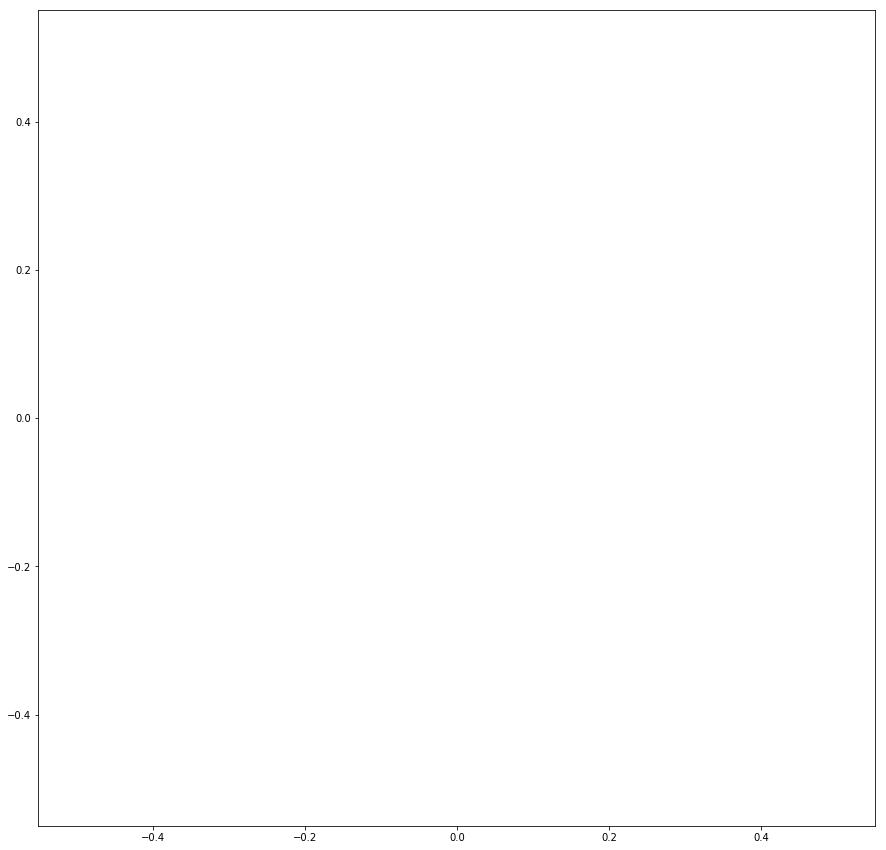

In [3]:
fig = plt.figure(figsize=(15, 15))
ax = plt.axes()
ax.set_xlim(-.55, 0.55)
ax.set_ylim(-.55, 0.55)

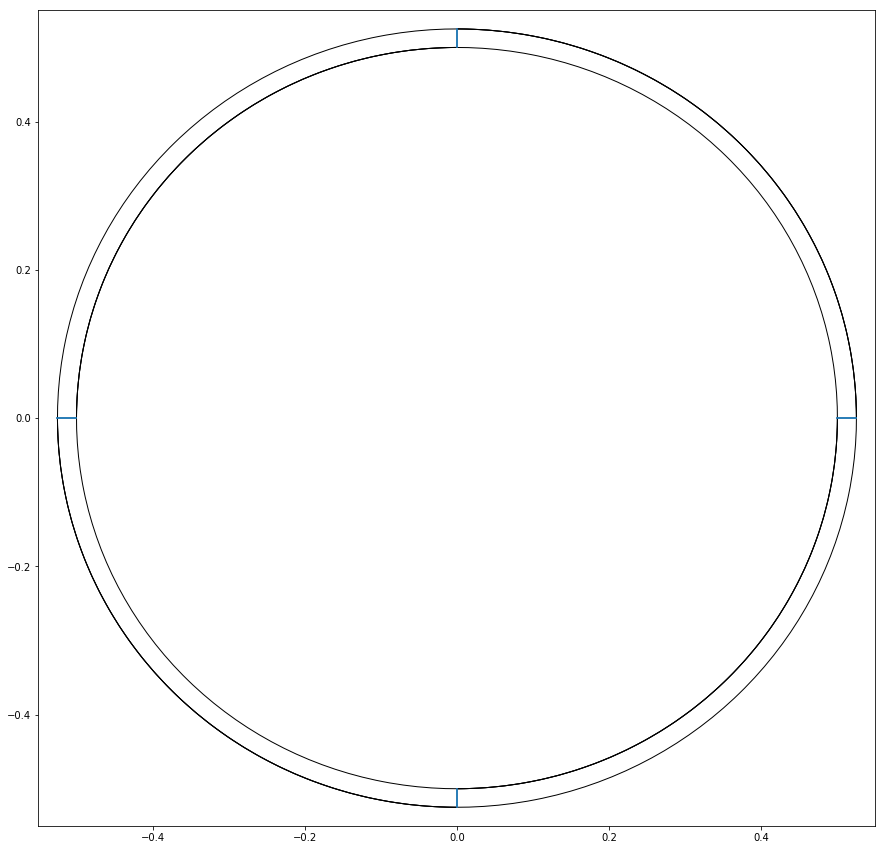

In [4]:
#Air far field
r = 0.5

kpc = Point.ofCartesian(0.0, 0.0)
kp1 = Point.ofCartesian(r, 0.0)
kp2 = Point.ofCartesian(0.0, r)

kp1_out = Point.ofCartesian(r*1.05, 0.0)
kp4_out = Point.ofCartesian(0.0, r*1.05)

ln1 = Line.ofEndPoints(kp1, kp1_out)
ln2 = Arc.ofEndPointsCenter(kp1_out, kp4_out, kpc)
ln3 = Line.ofEndPoints(kp4_out, kp2)
ln4 = Arc.ofEndPointsCenter(kp2, kp1, kpc)

ar1 = Area.ofHyperLines(a.create_hyper_line_array(gateway, (ln1, ln2, ln3, ln4)))
ar2 = ar1.mirrorY()
ar3 = ar2.mirrorX()
ar4 = ar1.mirrorX()

el1 = Element("FAR_El1", ar1)
el2 = Element("FAR_El2", ar2)
el3 = Element("FAR_El3", ar3)
el4 = Element("FAR_El4", ar4)

air_far_field = a.create_element_array(gateway, (el1, el2, el3, el4))

p.plot_multiple_areas(ax, [ar1, ar2, ar3, ar4])
fig

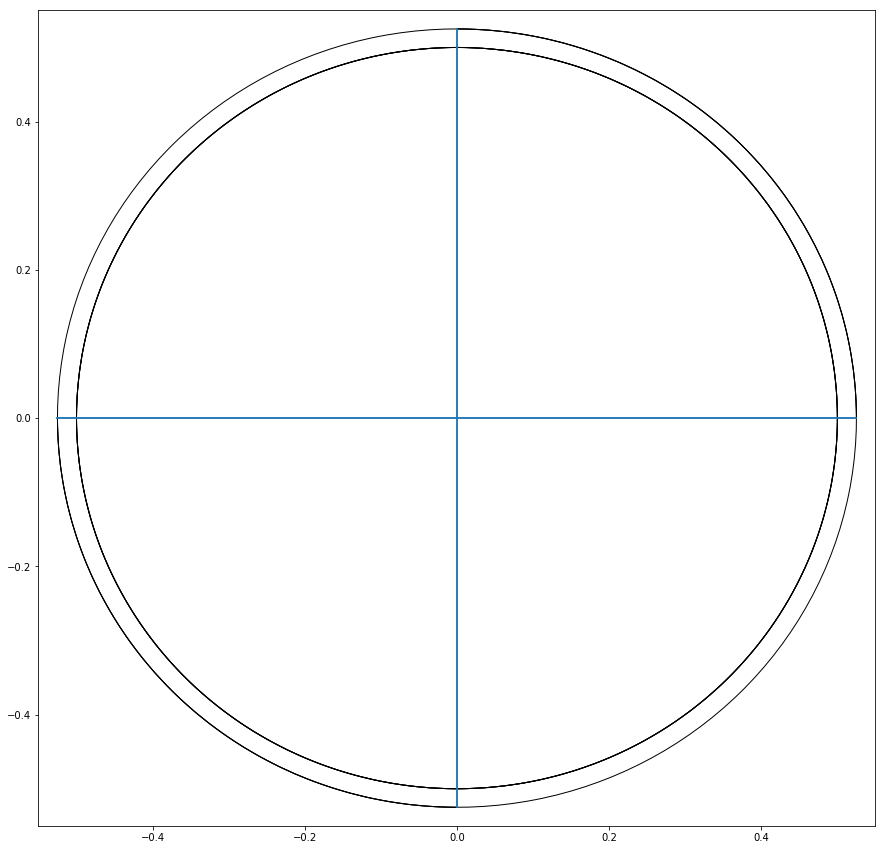

In [5]:
# Air domain
r = 0.5

kpc = Point.ofCartesian(0.0, 0.0)
kp1 = Point.ofCartesian(r, 0.0)
kp2 = Point.ofCartesian(0.0, r)

ln1 = Line.ofEndPoints(kpc, kp1)
ln2 = Arc.ofEndPointsCenter(kp1, kp2, kpc)
ln3 = Line.ofEndPoints(kp2, kpc)

ar1 = Area.ofHyperLines(a.create_hyper_line_array(gateway, (ln1, ln2, ln3)))
ar2 = ar1.mirrorY()
ar3 = ar2.mirrorX()
ar4 = ar1.mirrorX()

el1 = Element("AIR_El1", ar1)
el2 = Element("AIR_El2", ar2)
el3 = Element("AIR_El3", ar3)
el4 = Element("AIR_El4", ar4)

air = a.create_element_array(gateway, (el1, el2, el3, el4))

p.plot_multiple_areas(ax, [ar1, ar2, ar3, ar4])
fig

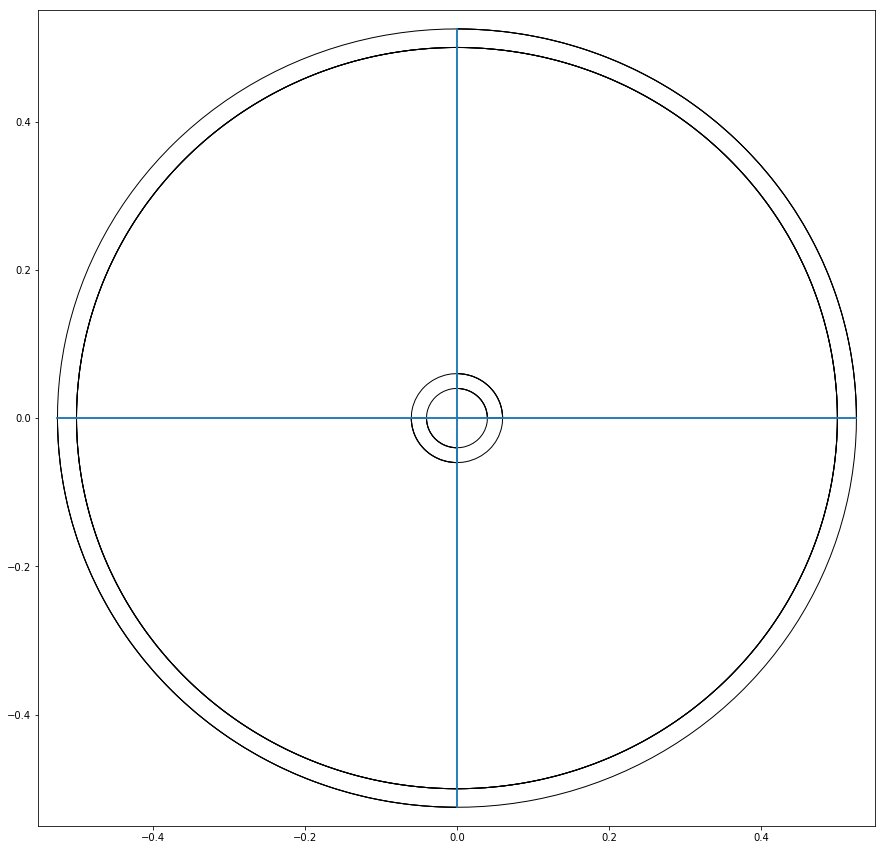

In [6]:
# iron yoke
deg2rad = np.pi/180
r_int = 0.04
r_ext = 0.06

kp1 = Point.ofPolar(r_int, 0 * deg2rad)
kp2 = Point.ofPolar(r_ext, 0 * deg2rad)
kp3 = Point.ofPolar(r_ext, 90 * deg2rad)
kp4 = Point.ofPolar(r_int, 90 * deg2rad)

kp0 = Point.ofCartesian(0.0, 0.0)

ln1 = Arc.ofEndPointsCenter(kp1, kp4, kp0)
ln2 = Line.ofEndPoints(kp1, kp2)
ln3 = Arc.ofEndPointsCenter(kp2, kp3, kp0)
ln4 = Line.ofEndPoints(kp4, kp3)

ar1 = Area.ofHyperLines(a.create_hyper_line_array(gateway, (ln1, ln2, ln3, ln4)))
ar2 = ar1.mirrorY()
ar3 = ar2.mirrorX()
ar4 = ar1.mirrorX()

el1 = Element("IY_El1", ar1)
el2 = Element("IY_El2", ar2)
el3 = Element("IY_El3", ar3)
el4 = Element("IY_El4", ar4)

iron_yoke = a.create_element_array(gateway, (el1, el2, el3, el4))

p.plot_multiple_areas(ax, [ar1, ar2, ar3, ar4])
fig

In [7]:
# cable parameters
cableT1 = Cable()
cableT1.setLabel("Cable_T1")
cableT1.setwInsulNarrow(100e-6)
cableT1.setwInsulWide(100e-6)
cableT1.setdFilament(50.0e-6)
cableT1.setDstrand(0.75e-3)
cableT1.setFracCu(0.6)
cableT1.setFracSc(0.4)
cableT1.setRRR(100.0)

cableT1.setTupRRR(295.0)
cableT1.setTop(1.9)
cableT1.setRc(100e-6)
cableT1.setRa(100e-6)
cableT1.setfRhoEff(1.0)
cableT1.setlTp(20e-3)
cableT1.setwBare(15e-3)
cableT1.sethInBare(1.5e-3)
cableT1.sethOutBare(1.5e-3)
cableT1.setNoOfStrands(40)
cableT1.setNoOfStrandsPerLayer(20)
cableT1.setNoOfLayers(2)
cableT1.setlTpStrand(0.1)
cableT1.setwCore(0.0)
cableT1.sethCore(0.0)
cableT1.thetaTpStrand = np.arctan2((15e-3-0.75e-3),(0.1/2))
cableT1.setC1(0.0)
cableT1.setC2(0.0)
cableT1.setFracHe(0.0)
cableT1.setFracFillInnerVoids(1.0)
cableT1.setFractFillOuterVoids(1.0)
cableT1.setCriticalSurfaceFit(Cable.CriticalSurfaceFitEnum.Ic_NbTi_GSI)
cableT1.setInsulationMaterial(MatDatabase.MAT_KAPTON)
cableT1.setMaterialInnerVoids(MatDatabase.MAT_VOID)
cableT1.setMaterialOuterVoids(MatDatabase.MAT_VOID)
cableT1.setMaterialCore(MatDatabase.MAT_VOID)
cableT1.setResitivityCopperFit(Cable.ResitivityCopperFitEnum.rho_Cu_CUDI)

JavaObject id=o446

## Coil

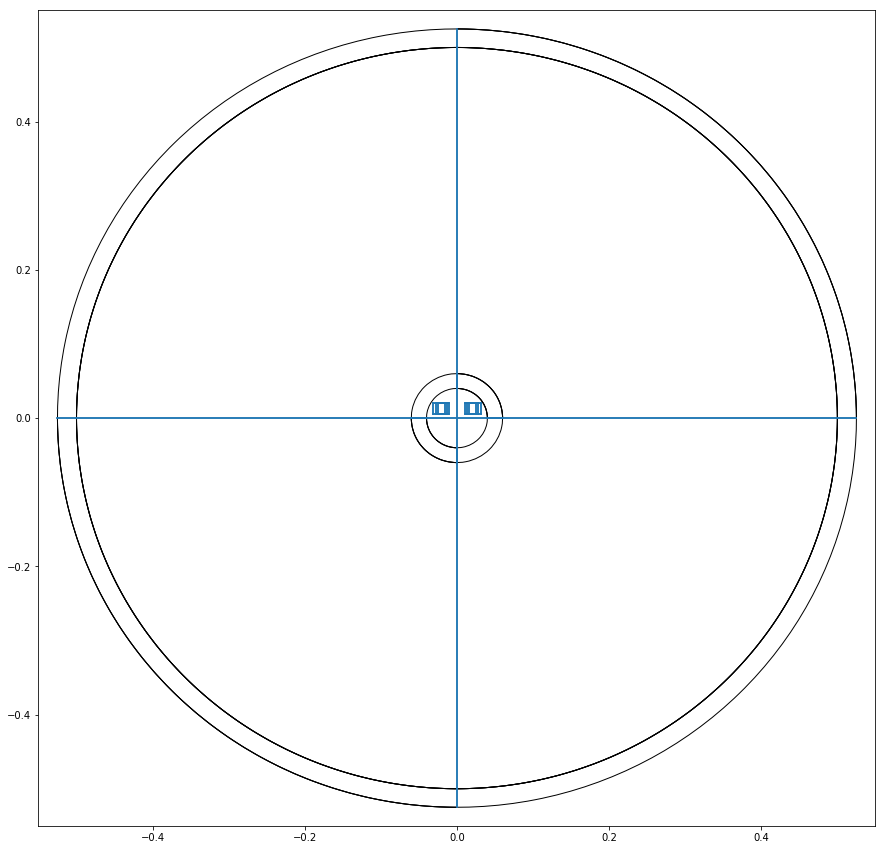

In [11]:
x0 = 0.01
y0 = 0.005
w = 15e-3
h = 1.5e-3

kp11 = Point.ofCartesian(x0, y0+w)
kp12 = Point.ofCartesian(x0, y0)
kp13 = Point.ofCartesian(x0+10*h, y0)
kp14 = Point.ofCartesian(x0+10*h, y0+w)


ln11 = Line.ofEndPoints(kp11, kp14)
ln12 = Line.ofEndPoints(kp12, kp11)
ln13 = Line.ofEndPoints(kp12, kp13)
ln14 = Line.ofEndPoints(kp13, kp14)

ha11p = Area.ofHyperLines(a.create_hyper_line_array(gateway, (ln11, ln12, ln13, ln14)))
ha12p = ha11p.translate(2*h,0.0)
ha13p = ha11p.translate(4*h, 0.0)

ha11n = ha11p.mirrorY()
ha12n = ha12p.mirrorY()
ha13n = ha13p.mirrorY()

w0 = Winding.ofAreas(a.create_area_array(gateway, (ha11p, ha11n)), a.create_int_array(gateway, (+1, -1)), 10, 10, cableT1)

p1 = Pole.ofWindings(a.create_winding_array(gateway, (w0)))
p2 = p1.mirrorX().reverseWindingDirection()

coil = Coil.ofPoles(a.create_pole_array(gateway, (p1, p2)))

p.plot_multiple_areas(ax, [ha11p, ha12p, ha13p, 
                         ha11n, ha12n, ha13n])
fig

## BH curve for the iron yoke

                0
0.0        0.0000
159.2      0.8000
294.4      1.2000
501.3      1.4000
795.8      1.5000
1154.0     1.5500
1795.0     1.6000
2862.0     1.6500
4383.0     1.7000
6044.0     1.7500
8122.0     1.8000
10590.0    1.8500
13160.0    1.9000
21170.0    2.0000
26750.0    2.0500
33760.0    2.1000
43800.0    2.1500
66000.0    2.2000
99740.0    2.2490
120960.0   2.2750
141210.0   2.3000
169600.0   2.3443
212170.0   2.3996
283130.0   2.4905
339890.0   2.5627
425040.0   2.6706
566950.0   2.8498
850760.0   3.2074
1702300.0  4.2782
2128000.0  4.8134
2837700.0  5.7052
3405100.0  6.4186
4256700.0  7.4887


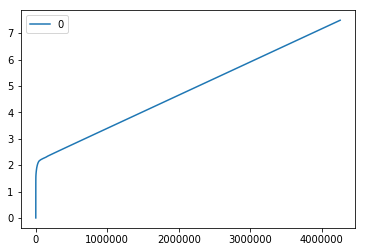

In [9]:
iron = IronDomain("iron_yoke", "../bh-curve-database.txt", "BH_SIGMA", iron_yoke)
mat = iron.getMaterial()
prop = mat.getProperties()
hb = prop[3].getValue()
b = []
h = []
for s in hb:
    b.append(float(s[0]))
    h.append(float(s[1]))
    
df = pd.DataFrame(b, h)
df.plot()
print(df)

In [12]:
# Assemble domains together
domains = a.create_domain_array(gateway, (AirDomain("airDomain", MatDatabase.MAT_AIR, air),
                AirFarFieldDomain("airFarFieldDomain", MatDatabase.MAT_AIR, air_far_field),
                CoilDomain("CO", MatDatabase.MAT_COIL, coil),
                #IronDomain("holes_yoke", MatDatabase.MAT_IRON1, iron_yoke),
                IronDomain("iron_yoke", "../bh-curve-database.txt", "BH_SIGMA", iron_yoke)))

In [13]:
# Create magnet model
cfg = ConfigSigma()
cfg.setOutputModelPath("T1MagnetModel.java")
cfg.setExternalCFunLibPath("U:\\STEAM\\MaterialsLibrary")

srv = TxtSigmaServer(cfg.getOutputModelPath(), cfg.getComsolBatchPath())
srv.connect(cfg.getComsolBatchPath())
m = MagnetMPHBuilder(cfg, srv)
m.buildMPH(domains)
m.save()

# Steps for the STEAM-SIGMA documentation to complete a model
<img src="../SolverSettings.PNG">
<img src="../PhysicsSettings.PNG">

# Magnetic field distribution

# Extract differential inductance as a function of current

# Calculate differential inductance matrix

# Create equivalent electrical network with STEAM - preconditioner

# Create circuit to be coupled to